# Learn a Koopman model using Extended Dynamic Mode Decomposition (EDMD)
In this example, we will train a linear Koopman model using EDMD (see Williams,
Kevrekidis & Rowley, _"A Data–Driven Approximation of the Koopman Operator: Extending
 Dynamic Mode Decomposition"_, Journal of Nonlinear Science 25, pp. 1307-1346, 2015)
for a nonlinear, dynamical system. The approach is demonstrated for discrete-time Van
 der Pol system in reverse time:

$$x_{k+1} = x_k - y_k dt,\\
y_{k+1} = y_k + (x_k-y_k+x_k^2y_k)dt$$

where $dt=0.1$ (this is example II from Surana & Banaszuk, _"Linear observer synthesis
for nonlinear systems using Koopman Operator framework"_, IFAC 49-18 (2016), pp.
716-723).

In [1]:
import pykoopman as pk
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

from pykoopman.common import rev_dvdp  # discrete-time, reverse-time van der Pol

### Collect training data
The training data consists of a snapshot pair taken from 51 uniformly distributed
random initial conditions.

In [2]:
n_states = 2  # Number of states
dT = 0.1      # Timestep
n_traj = 51   # Number of trajectories
n_int = 3     # Integration length

# Uniform distribution of initial conditions
x = xE = 2*rnd.random([n_states, n_traj])-1

# Init
X = np.zeros((n_states, n_int*n_traj))
Y = np.zeros((n_states, n_int*n_traj))

# Integrate
for step in range(n_int):
    y = rev_dvdp(0, x, 0, dT)
    X[:, (step)*n_traj:(step+1)*n_traj] = x
    Y[:, (step)*n_traj:(step+1)*n_traj] = y
    x = y

Text(0.5, 1.0, 'training data. num traj = 51, each traj time step = 3')

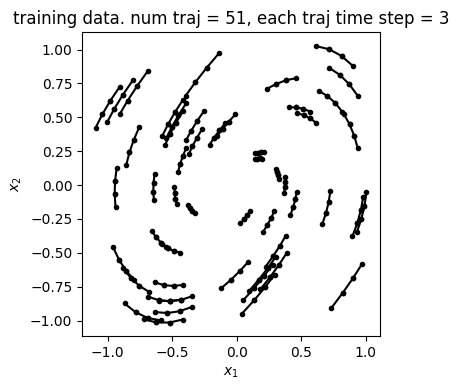

In [3]:
# Visualize first 100 steps of the training data
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(4, 4))
for traj_idx in range(n_traj):
    axs.plot([X[0, traj_idx::n_traj], Y[0, traj_idx::n_traj]],
             [X[1, traj_idx::n_traj], Y[1, traj_idx::n_traj]], '-ok',markersize=3)
axs.set(ylabel=r'$x_2$', xlabel=r'$x_1$')
axs.set_title('training data. num traj = {}, each traj time step = {}'.format(n_traj,n_int))

### Koopman regression using EDMD
As basis functions we choose thinplate radial basis functions.

In [4]:
EDMD = pk.regression.EDMD()
RBF = pk.observables.RadialBasisFunction(rbf_type='thinplate', n_centers=20,
                                         centers=None, kernel_width=1.0, 
                                         polyharmonic_coeff=1.0, include_state=True)

model = pk.Koopman(observables=RBF, regressor=EDMD)
model.fit(X.T, y=Y.T)

Koopman(observables=RadialBasisFunction(centers=array([[-0.47593423, -0.01280843,  0.9386398 , -0.63108572, -0.24694769,
         0.57614293, -0.67995601, -1.04198292, -0.53460636, -0.84110033,
         0.99141397,  0.70149992,  0.2848694 ,  0.85254145,  0.69089247,
        -0.78065346,  0.90285287,  0.06056963,  0.69987786,  0.91127602],
       [-0.36389254, -0.79828791, -0.55203857, -0.13598172,  0.68059397,
         0.76982415, -1.01365574,  0.03873502, -0.15623759, -0.56421148,
        -0.77778836, -0.32292516,  0.94149024, -0.35303126,  0.05553692,
         0.44037626, -0.26858295,  1.00180249,  0.98230281, -0.50222368]]),
                                        n_centers=20, rbf_type='thinplate'),
        regressor=EDMD())

### Prediction
First, we will use the fitted EDMD model to predict the evolution for a single
initial condition. The inverse transformation, i.e. from observables back to the
state, is estimated using least-squares regression within the Koopman regressor.
Afterwards, we will show the prediction performance for the training data.

In [5]:
# x0 = [0.6, -0.6]
x0 = np.array([0.5, -0.75])
T = 10
t = np.arange(0, T, dT)

# Integrate
Xtrue = np.zeros((len(t), n_states))
Xtrue[0, :] = x0
for step in range(len(t)-1):
    y = rev_dvdp(0, Xtrue[step, :][:, np.newaxis], 0, dT)
    Xtrue[step+1, :] = y.ravel()

# Simulate (multi-step prediction) Koopman model
Xkoop = model.simulate(x0[np.newaxis, :], n_steps=len(t)-1)
Xkoop = np.vstack([x0[np.newaxis,:], Xkoop])

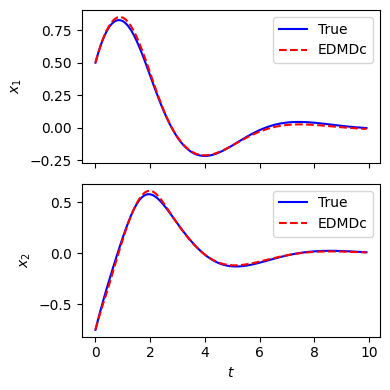

In [6]:
fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True, figsize=(4, 4))
axs[0].plot(t, Xtrue[:, 0], '-', color='b', label='True')
axs[0].plot(t, Xkoop[:, 0], '--r', label='EDMDc')
axs[0].set(ylabel=r'$x_1$')
axs[1].plot(t, Xtrue[:, 1], '-', color='b', label='True')
axs[1].plot(t, Xkoop[:, 1], '--r', label='EDMDc')
axs[1].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')
for i in range(2):
    axs[i].legend(loc='best')

In [7]:
# Init
Xk = np.zeros((n_states, n_int*n_traj))
Yk = np.zeros((n_states, n_int*n_traj))

# 1-step prediction using Koopman model
x = xE.T
for k in range(n_int):
    # print(k)
    yT = model.predict(x)
    y = yT.T
    Xk[:, k*n_traj:(k+1)*n_traj] = x.T
    Yk[:, k*n_traj:(k+1)*n_traj] = y
    x = y.T

# Visualize

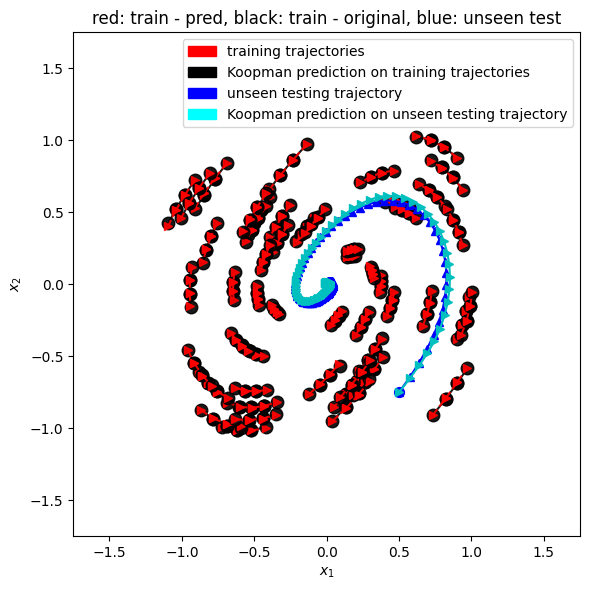

In [14]:

fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
legend_list = ['training - true', 'training - pred']
for traj_idx in range(n_traj):
    # label = legend_list[0] if traj_idx == 0 else None
    axs.plot([X[0, traj_idx::n_traj], Y[0, traj_idx::n_traj]],
             [X[1, traj_idx::n_traj], Y[1, traj_idx::n_traj]],'-ok',alpha=0.9,markersize=9)
    # label = legend_list[1] if traj_idx == 0 else None
    axs.plot([Xk[0, traj_idx::n_traj], Yk[0, traj_idx::n_traj]],
             [Xk[1, traj_idx::n_traj], Yk[1, traj_idx::n_traj]], '-->r',alpha=0.9)
axs.set(ylabel=r'$x_2$',
        xlabel=r'$x_1$')

axs.plot(Xtrue[:,0], Xtrue[:,1],'-^b')
axs.plot(Xkoop[:,0], Xkoop[:,1],'->c')

axs.scatter(x0[0],x0[1],s=50,c='b',label='unseen test')
axs.set_title('red: train - pred, black: train - original, blue: unseen test')

red_patch = mpatches.Patch(color='red', label='training trajectories')
black_patch = mpatches.Patch(color='black', label='Koopman prediction on training trajectories')
blue_patch = mpatches.Patch(color='blue', label='unseen testing trajectory')
cyan_patch = mpatches.Patch(color='cyan', label='Koopman prediction on unseen testing trajectory')

axs.set_xlim([-1.75,1.75])
axs.set_ylim([-1.75,1.75])

axs.legend(handles=[red_patch, black_patch, blue_patch, cyan_patch],loc='best', )
